## Introduction

Breast cancer is the most common cancer related cause of death among women. An early diagnosis a is a key element in determining the success of the treatment. The Wisconsin Diagnostic Breast Cancer data set was created by analysing imagines from a Fine Needle Aspirate (FNA) of breast mass and recording a series of measurements of the nuclei of the cells.

The goal of this project is to predict if a breast mass is benign or malignant using the available measurements. 

**Import the libraries and the dataset**

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
cancer = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')

**Check the structure of the dataset**

In [ ]:
print(f"Number of rows: {cancer.shape[0]}")
print(f"Number of columns: {cancer.shape[1]}")

**Change the setting to display all columns.**

In [ ]:
pd.set_option('display.max_columns', None)

### Dataset description

Variables Information:

**1) ID number**
**2) Diagnosis:** M = malignant; B = benign

**3-32)**

Ten real-valued features are computed for each cell nucleus:

**a) Radius:** mean of distances from center to points on the perimeter

**b) Texture:** standard deviation of gray-scale values

**c) Perimeter**

**d) Area**

**e) Smoothness:** local variation in radius lengths

**f) Compactness:** perimeter^2 / area - 1.0

**g) Concavity:** severity of concave portions of the contour

**h) Concave points:** number of concave portions of the contour

**i) Symmetry**

**j) Fractal dimension:** "coastline approximation" - 1

For each variable we have three types of measurements

**- Mean**

**- Standard Error**

**- Worst** (mean of the three largest values)

**Checking a few rows of the dataset**

In [ ]:
cancer.head()

In [ ]:
cancer.tail()

In [ ]:
cancer.sample(5)

### Data Cleaning

**Get general information about the dataset**

In [ ]:
cancer.info()

The column Unnamed: 32 contains only missing values while the id column contains the code of the sample. We can drop both columns from the dataset.

The dependent variable diagnosis contains categorical data: benign, malignant.
The idependent variables contain contiuous data of float type.

In [ ]:
cancer.drop(['id', 'Unnamed: 32'], axis = 1, inplace = True)

**Check for duplicated values**

In [ ]:
cancer.duplicated().any()

**Dataset summary**

- The dataset contains 1 dependent variable and 30 independent variables:

- The independent variables consist of ten chatacteristic of each nucleus of the cell and are divided in three types of measurements: mean, standard error and worst.

- The dataset contains no null values and no duplicated entries.

## Exploratory Data Analysis (EDA)

**Get the number and percentage of benign and malignant samples**

In [ ]:
plt.figure(figsize = (14, 4))

ax0 = plt.subplot(1, 2, 1)
ax1 = plt.subplot(1, 2, 2)

proportion = cancer['diagnosis'].value_counts()/cancer.shape[0]
malignant = len(cancer[cancer['diagnosis'] == 'M'])
benign = len(cancer[cancer['diagnosis'] == 'B'])

sns.countplot(x = 'diagnosis', data = cancer, 
              palette = ['grey', 'orange'], ax = ax0)
ax0.set_title('Number of Cases by Diagnosis', size = 13)
ax0.set_xlabel(None)
ax0.text(x = 0, y = 100, s = malignant, size = 11, 
         color = 'black', horizontalalignment = 'center')
ax0.text(x = 1, y = 100, s = benign, size = 11,
        color = 'black', horizontalalignment = 'center')
ax0.yaxis.set_visible(False)
sns.despine(left = True)

proportion.plot(kind = 'pie', autopct = '%.1f%%', 
                explode = [0, 0.05], shadow = True,
                labels = ['B', 'M'], colors = ['orange', 'grey'], 
                ax = ax1)
ax1.set_title('Percent of Cases by Diagnosis')
ax1.yaxis.set_visible(False)

plt.subplots_adjust(wspace = 0.5)
plt.show()

About 63% of the entries are benign and about 37% are malignant.

I will separate the dataset in the three groups mean, se and worst and analyze them separately.

In [ ]:
mean = [i for i in cancer.columns if i == 'diagnosis' or i[-1] == 'n']
cancer_mean = cancer[mean]

se = [i for i in cancer.columns if i == 'diagnosis' or i[-1] == 'e']
cancer_se = cancer[se]

worst = [i for i in cancer.columns if i == 'diagnosis' or i[-1] == 't']
cancer_worst = cancer[worst]

In [ ]:
cancer_mean.iloc[:, 1:].describe()

Concavity mean and concave point_mean have a min value of 0. Let's explore it a bit more to make sure that is a legit value and not the result of some problem in the dataset (i.e, missing values).

In [ ]:
len(cancer[cancer['concavity_mean'] == 0])

In [ ]:
len(cancer[cancer['concave points_mean'] == 0])

In [ ]:
cancer[(cancer['concavity_mean'] == 0) | 
       (cancer['concave points_mean'] == 0)]

All the samples with concavity_mean and concave point_mean = 0 are benign sample and have the corresponding se and worst measurements = 0. Apart from sample 473, the dimension of the others are into the first quartile. The data above do not suggest errors in data entry or other kind of problems, so I will continue with the analysis.

**Plot a pairwise scatter plot of the mean variables by diagnosis status and the distribution of each variable by diagnosis status.**

In [ ]:
sns.pairplot(cancer_mean, hue = 'diagnosis', 
             palette = ({'M': 'grey', 'B': 'orange'}))

The benign and malignant class seem to be well separated.

Many variables are strongly correlated. This could create a multicollinearity problem.

**Nuclei Dimension**

In [ ]:
dimensions = cancer[['diagnosis', 'radius_mean', 
                     'perimeter_mean', 'area_mean', 
                     'compactness_mean']]

In [ ]:
fig = plt.figure(figsize= (20, 5))

for i, j in enumerate(dimensions.columns[1:]):
    fig.add_subplot(1, 4, i+1)
    sns.boxplot(x = dimensions['diagnosis'], 
                y = dimensions[j], 
                palette = ['grey', 'orange'])
    plt.xlabel(None)
    plt.title(f"{j.title()} by Diagnosis")
    plt.ylabel(None)
    

plt.subplots_adjust(wspace = 0.3)
plt.show()

All the measure connected to the dimensions of the nuclei seem to be good predictors of malignancy. 

**Nuclei shape**

In [ ]:
shape = cancer[['diagnosis','smoothness_mean', 
                'concavity_mean', 'concave points_mean', 
                'symmetry_mean']]

In [ ]:
fig = plt.figure(figsize= (20, 5))

for i, j in enumerate(shape.columns[1:]):
    fig.add_subplot(1, 4, i+1)
    sns.boxplot(x = shape['diagnosis'], 
                y = shape[j], 
                palette = ['grey', 'orange'])
    plt.xlabel(None)
    plt.title(f"{j.title()} by Diagnosis")
    plt.ylabel(None)

plt.subplots_adjust(wspace = 0.3)
plt.show()

Also the variables connected with the shape of the nuclei are well se

In [ ]:
structure = cancer[['diagnosis', 'texture_mean', 
                    'fractal_dimension_mean']]

In [ ]:
fig = plt.figure(figsize= (20, 5))

for i, j in enumerate(structure.columns[1:]):
    fig.add_subplot(1, 4, i+1)
    sns.boxplot(x = structure['diagnosis'], 
                y = structure[j], 
                palette = ['grey', 'orange'])
    plt.xlabel(None)
    plt.title(f"{j.title()} by Diagnosis")
    plt.ylabel(None)

plt.subplots_adjust(wspace = 0.5)
plt.show()

Apart for fractal dimension, 

**Descriptive statistics and  pairplot graph for the standard error group of variables.**

In [ ]:
cancer_se.iloc[:, 1:].describe()

In [ ]:
sns.pairplot(cancer_se, hue = 'diagnosis', 
             palette = ({'M': 'grey', 'B': 'orange'}))

**Desctiptive statistics and pairplot for the worst set of variables**

In [ ]:
cancer_worst.iloc[:, 1:].describe()

In [ ]:
sns.pairplot(cancer_worst, hue = 'diagnosis', 
             palette = ({'M': 'grey', 'B' : 'orange'}))

**Change the labels B and M to 0 and 1, respectively.**

In [ ]:
cancer['diagnosis'] = cancer['diagnosis'].map({'M': 1, 'B': 0})

In [ ]:
plt.figure(figsize = (18, 12))

sns.heatmap(cancer.corr(), annot = True)

From the table above it is clear that many variables are strongly correlated to each other, which could cause multicollinearity. 

**Multicollinearity**

When two independent variables are strongly correlated to each other.

**Why is multicollinearity a problem?**

Multicollinearity affects the interpretability of the model. Consider the linear regression equation below.
 
y = b0 + b1x1 + b2x2
                                                    
Let's assume that x1 and x2 are highly correlated, which means that we can predict the value of one variable given the value of the other one.

The coefficient b1 measures how much the dependent variable y will vary when x1 increases of 1 unit while x2 remain constant (b2 measures the effect of b2). Because x1 and x2 influence each other, varying x1 will induce a variation in x2 that will also have an effect on y. So with multicollinearity it is impossible to understand the impact of the single variables on the dependent variable.

Although multicollinearity affects the interpretability, it does not necessarily affects the performance of a model, so deciding to reduce the multicollinearity problem it depends from our need to know which variables are actually contributing to the final result.

One of the most common solutions to multicollinearity is to keep only one of the highly correlated variables while dropping the others.



In the dataset above, radius, perimeter and area have a correlation of over 0.9, so I will keep radius and drop the others. 
I will also drop concavity_mean, texture_worst and concave points_worst.

I will store the columns to drop in a variable called drop_col.

In [ ]:
drop_col = ['perimeter_mean', 'area_mean', 'concavity_mean', 
            'perimeter_se', 'area_se', 'perimeter_worst', 
            'area_worst', 'radius_worst', 'texture_worst', 
            'concave points_worst']

## Model Train, Test and Evaluation

**Steps**

- Train, test and evaluate an SVM model using all the variables.

- Feature selection using correlation coefficient and Recursive Feature Elimination with Cross Validation (RFECV).

- Train, test and evaluate the model with the selected features.

- Compare the performance of the two models.


#### Support Vector Machine (SVM)

Support Vector Machine is an algorithm that can be used for both classification and regression. In a binary classification problem, the goal of an SVM algorithm is to find the line (in a two dimensional space) that better separate the two classes.

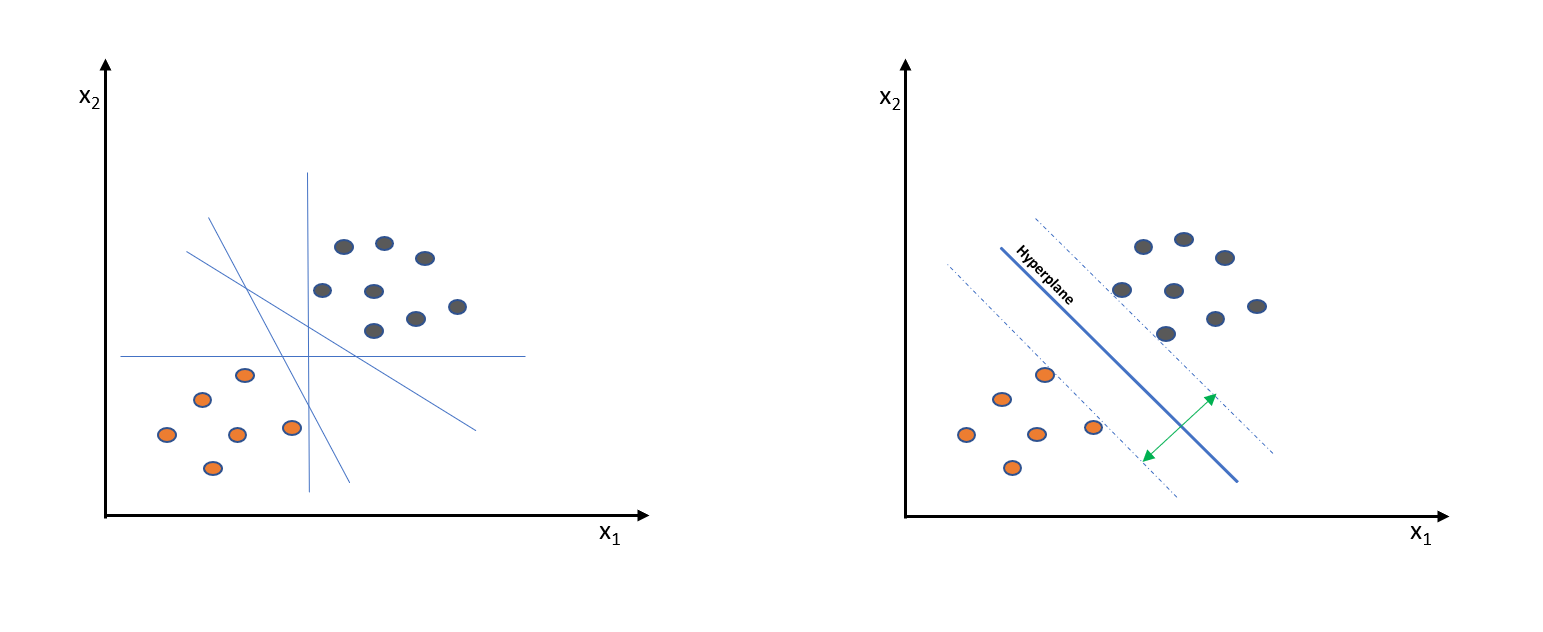

If we look at the figure on the left, there are several lines that can separate the two classes. The line that better separates the two classes is the one that ensures the widest margins at the two sides of the hyperplane (right figure). The datapoints closest to the  hyperplanes in both classes are called support vectors. They help determine the margine and the hyperplane to separate the classes. 

The margins between the two classes are not always easily separable with a straight line as in the example above. Sometimes we can have have a situation like the one in the left figure below.

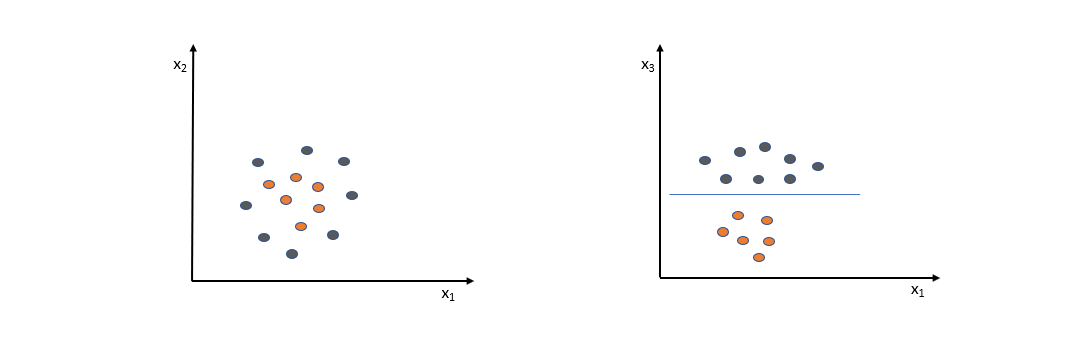

To separate these classes, the algorithm uses the so called kernel trick. The algorithm adds a dimension and now the two classes can be separated by a straight line again along the new dimension.

**Import the modules for Machne Learning**

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, classification_report

### Train and test an SVM model using all the variables

**Separate the independent variable from the dependent variable**

In [ ]:
X = cancer.drop('diagnosis', axis = 1)
y = cancer['diagnosis']

**Split the dataset in train(80%), and test(20%) set**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

**Scale the independent variables using Standard Scaler**

In [ ]:
std = StandardScaler()

In [ ]:
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

**Create an SVC object and train fit it to the train set**

In [ ]:
svc = SVC()

In [ ]:
svc.fit(X_train, y_train)

In [ ]:
y_train_predict = svc.predict(X_train)

In [ ]:
sns.heatmap(confusion_matrix(y_train, y_train_predict), 
            annot = True)
plt.title('Confusion matrix SVM (train set)', 
          size = 13)
plt.ylabel('Real Values', size = 11)
plt.xlabel('Predicted Values', size = 11)
plt.show()

In [ ]:
print(classification_report(y_train, y_train_predict))

**Perform cross-validation to evaluate the model**

I will use RepeatedStratifiedKFold to cross validate the model on the train set.

I will use 5 splits and 10 repetitions. 

- The dataset will be split in five parts. Four parts will be used to train the model and one part to test it. Each of the five part will in turn be used as test set, so one repetition produces five evaluation scores.

- The steps above will be repeated 10 times for a total of 50 train and test

- Get the average accuracy.

- I am also interested in the recall so I will perform the cross validation process again using recall as scoring metric.

In [ ]:
cv = RepeatedStratifiedKFold(n_splits = 5, 
                             n_repeats = 10, 
                             random_state = 10)

In [ ]:
accuracies = cross_val_score(svc, X = X_train, y = y_train, 
                             scoring = 'accuracy', cv = cv, 
                             n_jobs = -1)

**Accuracy**

In [ ]:
print(f"Accuracy:\nmean: {accuracies.mean():.3f}, std: {accuracies.std():.3f}")

**Recall**

In [ ]:
recalls_w = cross_val_score(svc, X = X_train, y = y_train, 
                            scoring = 'recall', cv = cv, 
                            n_jobs = -1)

In [ ]:
print(f"Recall:\nmean: {recalls_w.mean():.3f}, std: {recalls_w.std():.3f}")

The data for the cross validation are similar to the data from the train set. This means that the model can generalize well.

Let's see how it performs on the test set.

In [ ]:
y_predict = svc.predict(X_test)

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_predict), 
            annot = True)
plt.title('Confusion matrix SVM (test set)', 
          size = 13)
plt.ylabel('Real Values', size = 11)
plt.xlabel('Predicted Values', size = 11)
plt.show()

In [ ]:
print(classification_report(y_test, y_predict))

On the test set the model reached an accuracy of 0.97 that is similar to the accuracy obtained on cross validation.

The recall on the test set is 1.00 compared to 0.94 on cross-validation. Probably the way the dataset was split made it easy for the model to identify the positive class on the test set.

## Feature selection and second model training

In this section I will use two approaches to select the most relevant features for the model.

- First I will eliminate the features with an high correlation coefficient. I have already selected the feature to eliminate and stored them in the variable drop_col.

- Use Recursive Feature Elimination with Cross-Validation to select the most relevant features for the model.

In [ ]:
drop_col

**Create a new dataset without the features in drop_col.**

In [ ]:
cancer1 = cancer.drop(drop_col, axis = 1)
cancer1.shape

Now I have a dataset with 21 variables.

**Separate the independent variables from the dependent variable**

In [ ]:
X1 = cancer1.drop('diagnosis', axis = 1)
y1 = cancer1['diagnosis']

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1,
                                                        test_size = 0.2, 
                                                        random_state = 10)

**Scale the independent variables**

In [ ]:
std1 = StandardScaler()

In [ ]:
X1_train = std1.fit_transform(X1_train)
X1_test = std1.transform(X1_test)

**Recursive Feature Elimination Cross Validation (RFECV)**

Recursive Feature Selection trains a model using all the features available and computes the importance of each feature in the model. The least important features are eliminated from the model and the process is repeated until it reaches the selected number of features. To implement RFE we need to select an algorithm and the number of feature we want to use.

Because I do not know what the optimal number of features might be, I will use Recursive Feature Elimination with Cross Validation. In this case, the algorithm tries different combinations of variables and than selects the combination that returns the best mean score. I will use Logistic Regression as model for feature selection.

**Create an object for logistic regression and one for SVM**

In [ ]:
rfecv = RFECV(LogisticRegression())
svc1 = SVC()

**Create a pipeline for feature selection and model fitting**

In [ ]:
pipeline = Pipeline(steps = [('Feature Selection', rfecv), 
                             ('Model', svc1)])

**Let's use cross-validation to select the best features**

In [ ]:
rfecv.fit(X1_train, y1_train)

In [ ]:
rfecv.n_features_

RFECV selected 9 features out of the 21 available

Let's see which features contributed to the model.

In [ ]:
rfecv.support_

In [ ]:
features1 = pd.DataFrame(rfecv.support_, index = X1.columns, 
                         columns = ['Features'])

In [ ]:
features = features1[features1['Features'] == True].index
features

**Apply cross validation with the 9 features**

In [ ]:
cv = RepeatedStratifiedKFold(n_splits = 5, 
                             n_repeats = 10, 
                             random_state = 10)

In [ ]:
accuracies_rfe = cross_val_score(pipeline, X = X1_train, 
                                 y = y1_train, scoring = 'accuracy', 
                                 cv = cv, n_jobs = -1)

**Accuracy**

In [ ]:
print(f"Accuracy:\nmean: {accuracies_rfe.mean():.3f}, std: {accuracies_rfe.std():.3f}")

**Recall**

In [ ]:
recalls_rfe = cross_val_score(pipeline, X = X1_train, 
                              y = y1_train, scoring = 'recall', 
                              cv = cv, n_jobs = -1)

In [ ]:
print(f"Recall:\nmean: {recalls_rfe.mean():.3f}, std: {recalls_rfe.std():.3f}")

Both accuracy and recall of the model trained with  9 variables are into 0.01 distance from the same metrics from the model with all the variables. 

I am curious to check its performance on the test set using the 9 feature selected. I will take the train and test set I created before and keep only the 9 features selected by RFECV.

In [ ]:
X1_train_lr = pd.DataFrame(X1_train)

In [ ]:
X1_train_lr = X1_train_lr.iloc[:, [0, 1, 4, 7, 10, 13, 15, 17, 18]]

In [ ]:
X1_test_lr = pd.DataFrame(X1_test)

In [ ]:
X1_test_lr = X1_test_lr.iloc[:, [0, 1, 4, 7, 10, 13, 15, 17, 18]]

**Fit a new the model to the train set with 9 variables**

In [ ]:
svc2 = SVC()

In [ ]:
svc2.fit(X1_train_lr, y1_train)

In [ ]:
X1_train_lr.shape


**Let's see how the model performs on the test set**

In [ ]:
y1_predict = svc2.predict(X1_test_lr)

In [ ]:
sns.heatmap(confusion_matrix(y1_test, y1_predict), annot = True)
plt.title('Confusion matrix SVM-9 (test set)', 
          size = 13)
plt.ylabel('Real Values', size = 11)
plt.xlabel('Predicted Values', size = 11)
plt.show()

In [ ]:
print(classification_report(y1_test, y1_predict))

The model with 9 variables reached an accuracy of 0.99 and a recall of 1.00 on the test set.
Once again the way the dataset was split might have helped the performance of the model.

**Compare the results of cross validation of the model with all variables and the model with 9 variables.**

In [ ]:
models = pd.DataFrame({'SVM': {'accuracy': accuracies.mean(), 'a_std': accuracies.std(), 
                    'recall': recalls_w.mean(), 'r_std': recalls_w.std()},
                       
                      'SVM_9': {'accuracy': accuracies_rfe.mean(), 'a_std': accuracies_rfe.std(),
                      'recall': recalls_rfe.mean(), 'r_std': recalls_rfe.std()}})

In [ ]:
models.T

## Conclusion



In this notebook, I used SVM to predict the malignancy of breast masses based on measurements of the nuclei of the cells.

I first trained a model using all the variables available in order to have a baseline. I then used the correlation among features and recursive feature elimination with cross validation to reduce the number of feature ending up using 9 features instead of 30.

Reducing the number of features reduces the complexity of the model and increases its interpretability. 

Thank you for reading.

If you found the notebook interesting please upvote.

**Feedbacks are really apprecited.**
